# Анализ товарного ассортимента интернет-магазина

### Материалы

- **Дашборд** https://public.tableau.com/views/Dashboard_internet_magazine/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link 

***Описание проекта***

Интернет-магазин продает товары для дома и быта. Нам предстоит провести полноценный анализ товарного ассортимента и разобраться, какие товары входят в основной и дополнительный ассортимент. Такие меры необходимы, чтобы грамотно предлагать покупателям дополнительные товары и оптимизировать закупки магазина.

***Описание данных***

Датасет ecommerce_dataset.csv описывает транзакции интернет-магазина товаров для дома и быта.
- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

Работа будет состоять из следующих шагов:

- Шаг 1. Загрузим данные и подготовим их к анализу
- Шаг 2. Изучим и проверим данные
- Шаг 3. Определим для каждой категории основные и дополнительные товары
- Шаг 4. Сформируем и проверим гипотезы
- Шаг 5. Напишем общий вывод и сделаем рекомендации

### Шаг 1. Загрузим данные и подготовим их к анализу

#### Откроем файл с данными и изучим общую информацию

In [1]:
from io import BytesIO
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from math import factorial
from scipy import stats as st
from pymystem3 import Mystem

In [2]:
spreadsheet_id = "13Ncve0RWm1moW1pjt6rmUr1IogFPxA4eP918ADQGjxU"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


None

В нашем датасете более 6.7 тыс. строк и шесть столбцов. Пропусков в данных нет, однако есть проблемы с типом данных. Во-первых, столбец date необходимо перевести из int в datetame, во-вторых, для удобства, столбец price переведем в целочисленные значения. Также приведем к нижнему регистру значения столбца product.

####  Откорректируем типы данных

In [3]:
df['date'] = pd.to_datetime(df['date'].astype(str), format = '%Y%m%d%H')
df['price'] = df['price'].astype(int)

#### Приведем значения столбца product	к нижнему регистру

In [4]:
df['product'] = df['product'].str.lower()

#### Проверим пропуски

In [5]:
print('Количество дубликатов:',df.duplicated().sum())

Количество дубликатов: 0


Проверим дубликаты без значения даты. Так как у нас нет воронки продаж, мы не знаем, как действия покупателя распределились во времени.

In [6]:
print ('Количество дубликатов:',
        df.loc[df.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price']) == True].shape[0])

Количество дубликатов: 1864


In [7]:
df.duplicated('order_id').head(20)

0     False
1      True
2      True
3      True
4      True
5      True
6      True
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17     True
18     True
19    False
dtype: bool

Почти 30% данных дублируются, если отбросить столбец с датой. Посмотрим на такие дубли.

In [8]:
df.query('order_id == 73137 or order_id == 68476') 

,date,customer_id,order_id,product,quantity,price
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"мини-сковорода marmiton ""сердце"" с антипригарн...",1,239
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,сковорода алюминиевая с антипригарным покрытие...,1,824
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,стеклянная крышка для сковороды alpenkok 26 см...,1,262
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"сушилка для белья напольная colombo star 18, 3679",1,1049
273,2018-10-16 17:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"мини-сковорода marmiton ""сердце"" с антипригарн...",1,239
274,2018-10-16 17:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,сковорода алюминиевая с антипригарным покрытие...,1,824
275,2018-10-16 17:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,стеклянная крышка для сковороды alpenkok 26 см...,1,262
276,2018-10-16 17:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"сушилка для белья напольная colombo star 18, 3679",1,1049
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087
6736,2019-10-31 16:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,сумка-тележка 2-х колесная gimi argo синяя,1,1087


Мы видим, что если отбросить даты, то заказы полностью дублируют себя. Вероятнее всего, покупатель сначала положил товар в корзину, затем - купил. Удалим дубликаты.

In [9]:
df = df.drop_duplicates(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price']).reset_index(drop=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4873 entries, 0 to 4872
Data columns (total 6 columns):
date           4873 non-null datetime64[ns]
customer_id    4873 non-null object
order_id       4873 non-null int64
product        4873 non-null object
quantity       4873 non-null int64
price          4873 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 228.5+ KB


Стоит также проверить, нет ли дублей в 'customer_id'.  Посчитаем уникальные id юзеров для каждого id заказа.

In [10]:
id_order_customer = df.groupby('order_id')['customer_id'].nunique().sort_values(ascending = False).reset_index()
#id_order_customer = id_order_customer.query('customer_id > 1')
id_order_customer = id_order_customer.rename(columns = {'customer_id':'n_customer'})
id_order_customer

,order_id,n_customer
0,72845,4
1,71480,3
2,69485,3
3,71461,2
4,69310,2
...,...,...
2779,71328,1
2780,71324,1
2781,71322,1
2782,71320,1


In [11]:
df.query('order_id == 72845 or order_id == 71480') 

,date,customer_id,order_id,product,quantity,price
3392,2019-05-21 02:00:00,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74
3447,2019-05-24 22:00:00,d8080f8f-3685-433b-b416-beb0a8f06606,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74
3448,2019-05-25 02:00:00,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74
4674,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,муляж яблоко зеленый 9 см полиуретан,40,59
4675,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,муляж яблоко зеленый 9 см полиуретан,40,59
4677,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,муляж яблоко зеленый 9 см полиуретан,40,59
4703,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,муляж яблоко зеленый 9 см полиуретан,40,59


Мы определили, что для некоторые заказы были сделаны с разных 'customer_id'. Вероятнее всего это ошибка в данных, ведь если заказ есть, то он присвоен одному пользователю, даже если он заходит с разных устройств. Другое предположение, что нумерация заказов не сбросилась, например, с начала года. Удалим строки, где для каждого 'order_id' больше одного уникального 'customer_id'.

In [12]:
df = pd.merge(df, id_order_customer, on = 'order_id', how = 'outer')
df = df.loc[df['n_customer'] == 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4872
Data columns (total 7 columns):
date           4807 non-null datetime64[ns]
customer_id    4807 non-null object
order_id       4807 non-null int64
product        4807 non-null object
quantity       4807 non-null int64
price          4807 non-null int64
n_customer     4807 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 300.4+ KB


#### Изучим, нет ли аномальных значений в значениях цены и количестве товара в заказе

Посмотрим, изменяется ли цена, для одинаковых наименований товара. Затем проанализируем на минимальные, максимальные и медианные значения, построим боксплот.

In [13]:
product_price = df.groupby('product')['price'].agg('unique').reset_index()
product_price.loc[product_price ['price'].apply(lambda x: len(x)) > 1].head(10)

,product,price
2,tepмокружка avex recharge 500 мл голубой avex0681,"[2324, 1874]"
11,аквилегия обыкновенная барлоу микс объем 1 л,"[89, 105]"
16,алоэ вера d-12 см h-25 см,"[134, 239]"
23,антуриум андрианум ванилла d-12 см,"[547, 659]"
28,антуриум тропик найт нидерланды 1 штука в упак...,"[224, 262]"
48,базилик зеленый тонус d-7 см,"[15, 14]"
49,базилик овощной арарат d-7 см,"[15, 14]"
53,базилик пурпурные звезды d-7 см,"[15, 14]"
57,бакопа ампельная махровая белая махровая объем...,"[82, 90]"
58,бакопа ампельная махровая сиреневая махровая о...,"[82, 90]"


Мы определили, что на одни и те же товары выставлены разные цены. Но это можно объяснить, у кого-то есть скидочные карты или какие-то льготные привелегии.

In [14]:
df[['quantity', 'price']].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,4807.0,2.809861,17.684361,1.0,1.0,1.0,1.0,1000.0
price,4807.0,514.866029,946.464278,9.0,90.0,150.0,488.0,14917.0


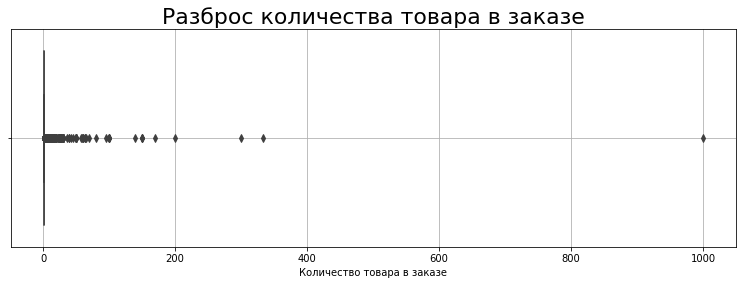

In [15]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x = "quantity")
plt.title('Разброс количества товара в заказе', fontsize=22)
plt.xlabel('Количество товара в заказе')
plt.grid()
plt.show()

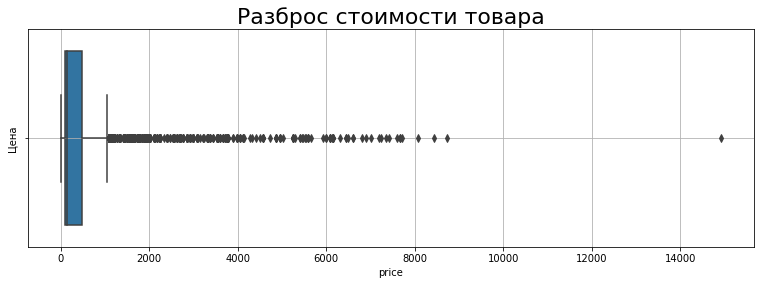

In [16]:
plt.figure(figsize=(13,4))
sns.boxplot(data=df, x = "price")
plt.title('Разброс стоимости товара', fontsize=22)
plt.ylabel('Цена')
plt.grid()
plt.show()

Судя по диаграмме размаха цены и объемы заказов, выходящие за пределы размаха "усов" или Q3+1.5 * iqr, являются выбросами. Посмотрим детальнее на совсем редкие значения, после чего решим, удалять ли их. Возбмем пороговое значение для количества товара 190, для цены - 8000. Именно после этих значений встречаются редкие выбросы. Возможно меньшие значения не будут такими уж аномальными, так как юзер мог сделать большой заказ или купить дорогой дизайнерский предмет. 

In [17]:
df.query('quantity > 190 or price > 8000')

,date,customer_id,order_id,product,quantity,price,n_customer
1016,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29,1
1704,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437,1
2311,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737,1
2565,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077,1
3392,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51,1
3775,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148,1
3842,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675,1
4221,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917,1


Все, кроме заказа "Вантуз с деревянной ручкой" в количестве 1000 шт, не вызывает вопросов, 200-300 небольших или недорогих товаров могут быть заказом какой-нибудь организации. А вот цены вполне реальные, проверили в открытых источниках, поэтому удаляем только вантузы.

In [18]:
df = df.loc[df['quantity'] != 1000]

In [19]:
df.shape

(4806, 7)

#### Добавим столбец дня, недели, месяца

In [20]:
df['date_day'] = df['date'].dt.date
df['date_week'] = df['date'].astype('datetime64[W]')
df['date_month'] = df['date'].astype('datetime64[M]')

#### Посмотрим, данными за какой период мы располагаем: найдем максимальную и минимальную дату

In [21]:
df['date'].describe().T

count                    4806
unique                   2183
top       2019-04-27 16:00:00
freq                       51
first     2018-10-01 00:00:00
last      2019-10-31 14:00:00
Name: date, dtype: object

##### Выводы

В первом шаге исследовательской работы мы загрузили и подготовили данные для дальнейшего анализа. Мы проверили пропуски и дубликаты, откорректировали типы данных, привели написания значений в единый удобный вид, проверили нет ли в данных аномальных значений. Также для дальнейших вычислений мы создали несколько дополнительных столбцов: добавили столбец дня, недели, месяца. Мы располагаем данными с начала октября 2018 года по конец октября 2019 года.

### Шаг 2. Определим основные и дополнительные товары

#### Создадим категории товаров

In [22]:
""" Разобьем предложения на леммы, напишем функцию, которая приведет слова к их словарной форме """
m = Mystem()

def lim(product): 
    lemmas = ''.join(m.lemmatize(product)).strip()
    return lemmas 
df['product_lem'] = df['product'].apply(lim)

In [23]:
""" Посмотрим на 10 самых популярных товаров """
(
    df.groupby('product_lem').agg({'order_id': 'count'})
    .sort_values(by ='order_id', ascending = False).head(10)
)

,order_id
product_lem,
пеларгония розебудный red pandora укоренять черенок,64
пеларгония розебудный prins nikolai укоренять черенок,53
пеларгония зональный диам. 12 см сиреневый полумахровый,52
сумка-тележка 2-х колесный gimi argo синий,47
пеларгония розебудный mary укоренять черенок,39
пеларгония розебудный queen ingrid укоренять черенок,30
пеларгония розебудный margaretha укоренять черенок,29
пеларгония зональный ринго вайт d-7 см h-10 см укоренять черенок,24
пеларгония зональный махровый лососевый,24


In [24]:
""" Удалим из столбца с леммами все слова, кроме первого """

df['product_lem'] =df['product_lem'].str.split(' ',1).str[0]

In [25]:
""" Сгруппируем товары по количеству заказов, отсортируем по убыванию, 
запишем в новую переменную все товары, по которым проводились операции больше двух раз """

produc_list = (
    df.groupby('product_lem').agg({'order_id': 'count'})
    .sort_values(by ='order_id', ascending = False)
    .reset_index()
)
produc_list = produc_list.query('order_id > 2')
produc_list.head(10)

,product_lem,order_id
0,пеларгония,702
1,рассада,478
2,сушилка,267
3,сумка-тележка,233
4,муляж,167
5,томат,148
6,петуния,139
7,гладильный,119
8,герань,110
9,коврик,104


In [26]:
# Можем посмотреть уникальные названия товаров 
#produc_list['product_lem'].unique()

Теперь есть возможность разделить все товары на категории. У нас их будет 5:
- цветы и семена
- хозтовары
- декор
- кухня
- другое

В категорию "другое" войдут товары, операции по которым проводились меньше трех раз, или товары, которые мы не смогли отнести к какой-то конкретной категории.

In [27]:
flowers_seeds = ['рассада', 'тагетис', 'бакоп', 'калибрахоа', 'пеларгония', 'вербена', 'томат', 
                 'петуния', 'лобелия', 'герань', 'дыня', 'вербейник', 'портулак', 'барвинок', 'базилик', 
                 'арбуз', 'однолетний', 'клубника', 'роза', 'декабрист', 'патиссон', 'огурец','газание', 
                 'бальзамин', 'фуксия', 'декоративный', 'примула', 'цветок', 'многолетний', 'баклажан', 
                 'флокс', 'колокольчик', 'виола', 'лавр', 'эвкалипт', 'сельдерей', 'капуста', 'калла', 
                 'кофе', 'камнеломка', 'кабачок', 'тыква', 'вигна', 'фиалка', 'циперус', 'пуансеттия', 
                 'алиссум','цикламен', 'розмарин', 'спатифиллум', 'бегония','дендробиум', 'скиммия', 
                 'нефролепис', 'овсянница', 'ясколка', 'петрушка', 'табак','котовник', 'мята', 'лапчатка', 
                 'седум', 'земляника', 'нивянник''кореопсис', 'цинерания', 'лен', 'эхинацея', 'целозия', 'хризантема', 
                 'тимьян', 'пиретрум', 'комнатный', 'аквилегия', 'бадан', 'сантолина', 
                 'иссоп', 'колеус', 'агератум', 'цинния', 'цинерария', 'календула', 'астра', 'монард', 'лаванда', 
                 'папоротник', 'салат', 'укроп', 'физостегия', 'бузульник', 'солидаго', 'настурция', 'валериана', 
                 'любисток', 'шалфей', 'змееголовник', 'буддлей', 'хоста', 'хлорофитум', 'сальвия', 'годеция', 
                 'эшшольция', 'кориандр', 'антуриум','калатея', 'мимоза', 'незабудка', 'мирт','горох', 
                 'эхеверие', 'зверобой', 'гардения', 'каланхое', 'каллун', 'капсикум', 'соланум',  
                 'вероника', 'мединилла','анемон', 'душица', 'гербера', 'нолина', 'гайлардий', 'георгин', 
                 'мелисса', 'бархатцы', 'смолевка', 'рудбекия', 'морковь','маттиола', 'аргирантерум', 'фаленопсис',
                 'юкка', 'радермахер', 'хризолидокарпус', 'азалия', 'лилейник', 'энотера', 'крассула', 'чабер', 
                 'платикодон', 'лаватер', 'гортензия', 'алоэ', 'лук', 'ранункулус', 'цветущий','молодило',  
                 'мускарь', 'осина', 'гипсофил', 'аптение', 'адиантум', 'лантан','циния', 'диффенбахий', 
                 'афеляндра','аспарагус', 'артемизия']


household_goods = ['сумка-тележка', 'сушилка', 'гладильный', 'чехол', 'таз', 'тележка', 'термометр', 'щетка', 
                   'подвесной', 'контейнер', 'петля', 'вешалка', 'набор', 'сидение', 'ерш', 'стремянка', 
                   'швабра', 'лестница-стремянка', 'корзина', 'корыто', 'кофр', 'насадка', 'подрукавник', 
                   'средство', 'стяжка', 'шнур', 'коробка', 'наматрасник', 'наматрицник-чехол', 'одеяло', 
                   'скребок', 'подголовник', 'многофункциональный', 'щетка-сметка', 'короб', 
                   'щетка-утюжок', 'сумка', 'крючок', 'жестяной', 'простыня', 'веник', 'комнатный', 'мусорный', 
                   'вешалка-плечики', 'полотенце', 'плечики', 'кипятильник', 'ведро', 'окномойка', 'ящик', 'штанга',
                   'универсальный', 'подушка', 'крепеж', 'завертка', 'петля-стрела', 'комплект', 'шило', 'махровый', 
                   'пружина', 'держатель', 'сменный', 'подставка', 'мыло', 'ролик', 'пена', 'жидкий',  'фен', 
                   'стремянка-табурет', 'стиральный', 'шприц', 'покрытие', 'кондиционер', 'бальзам', 'лоток', 
                   'нетканый','ароматизированный', 'антинакипин', 'наматрацник', 'совок', 'шпагат', 'сетка', 
                   'дозатор', 'утюг', 'паста']

decor = ['муляж', 'коврик', 'штора', 'искусственный', 'скатерть', 'ковер', 'подарочный', 'светильник', 
         'карниз', 'полка', 'комнатный', 'вешалка-плечики', 'плед', 'урна-пепельница', 'этажерка', 
         'комод', 'стеллаж', 'покрывало', 'вешалка-стойка', 'урна', 'полк', 'измерительный']

kitchen = ['салфетка', 'чайник','кисточка', 'салатник', 'банка', 'перчатка', 'ложка', 'весы', 'пробка', 
           'рыбочистка', 'миска', 'нож', 'вилка', 'кружка', 'тарелка', 'стакан', 'лопатка', 'подкладка', 
           'чайный', 'столовый', 'сковорода', 'блюдо', 'доска', 'салфетница','мини-сковорода', 'кувшин', 
           'кухонный', 'термокружок', 'антижир', 'емкость', 'блюдце', 'скалка', 'разделочный', 'терка', 
           'кастрюля', 'губка', 'термос', 'форма', 'защитный', 'хлебница', 'тряпкодержатель', 'электроштопор', 
           'чистить', 'тортница', 'tepмокружка', 'измельчитель', 'половник', 'ароматизированный', 'антинакипин', 
           'миксер', 'овощеварка', 'термостакан', 'утюг', 'измерительный', 'ковш']


In [28]:
""" Создадим функцию, которая вернет название категории, если столбце найдутся слова из наших переменных """

def category(row):
    if row['product_lem'] in flowers_seeds:
        return 'цветы и семена' 
    elif row['product_lem'] in household_goods:
        return 'хозтовары'
    elif row['product_lem'] in decor:
        return 'декор'
    elif row['product_lem'] in kitchen:
        return 'кухня'
    else:
        return'другое'
df['category'] = df.apply(category, axis=1)

#### Изучим сколько всего событий в каждой категории

In [29]:
df['category'].value_counts()

цветы и семена    2422
хозтовары         1351
декор              526
кухня              307
другое             200
Name: category, dtype: int64

#### Определим основной и дополнительный товар

Чтобы определить какой товар является основным, а какой дополнительным,  мы поделим клиентов на постоянных и непостоянных.

In [30]:
""" Создадим новую переменную, где сгруппируем id покупателей и категории и посчитаем для них количество товаров. """

product_category = (
    df.groupby(['customer_id', 'category'])['product'].count()
    .reset_index().sort_values('product', ascending = False)
)

""" Сumcount посчитает количество действий покупателей, сколько раз юзер что-то покупал"""
product_category['cumcount'] = (
    product_category.sort_values(['customer_id', 'product'], ascending = False)
    .groupby('customer_id').cumcount()
)
product_category.head(3)

,customer_id,category,product,cumcount
1942,c971fb21-d54c-4134-938f-16b62ee86d3b,хозтовары,83,0
2053,d3b9ffea-d143-4747-8d59-74ab843d1ad6,цветы и семена,51,0
1132,760aa067-90c3-4794-b7a9-a8831197388b,цветы и семена,35,0


У нас получилась таблица, в которой для каждого id клиента прописана категория, количество продуктов, которые он покупал, название категории этих продуктов и количество действий клиента. Дальше поделим клиентов на не постоянных и условно постоянных.

In [31]:
def category_id(category, product, cumcount):
    if product <= 1 and cumcount == 0:
        return 'не постоянный клиент'
    if cumcount == 0:
        return category
    """ Создадим функцию, где для продукта, заказанного один или меньше раз и клиентов, покупавших что-либо только раз
    будет создана метка не постоянный клиент. Остальным - вернется название товарной категории """

In [32]:
""" Добавим новый столбец в product_category """
product_category['category_id'] = product_category.apply(lambda x: category_id(x['category'],
                                                                                 x['product'], 
                                                                                 x['cumcount']), axis = 1)

In [33]:
""" Соеденим таблицу с основным датафреймом, но перед этим удалим дубликаты и ненужные столбцы,  """
product_category = product_category.drop_duplicates('customer_id', keep = 'first')
del product_category['category']
del product_category['product']
del product_category['cumcount']
df = pd.merge(df, product_category, on = 'customer_id', how = 'outer')
df.head(3)

,date,customer_id,order_id,product,quantity,price,n_customer,date_day,date_week,date_month,product_lem,category,category_id
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,1,2018-10-01,2018-09-27,2018-10-01,комнатный,цветы и семена,цветы и семена
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,1,2018-10-01,2018-09-27,2018-10-01,комнатный,цветы и семена,цветы и семена
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,1,2018-10-01,2018-09-27,2018-10-01,радермахер,цветы и семена,цветы и семена


Теперь нам предстоит разделить ассортимент на основной и дополнительный. Будем исходить из логики, что основной товар покупается постоянными пользователями, а также покупается чаще одного раза.  

In [34]:
def assortment_of_categories(category, category_id):
    if category == category_id:
        return 'основной'
    else:
        return 'дополнительный'
    """ Создадим функцию, где для каждой категории товаров равной значению 'category_id',
    ассортимент будет определен как основной, в другом случае как дополнительный """

In [35]:
df['assortment'] = (
    df.apply(lambda x: assortment_of_categories(x['category'], x['category_id']), axis = 1)
)

In [36]:
df['assortment'].value_counts()

основной          2668
дополнительный    2138
Name: assortment, dtype: int64

##### Вывод

Во втором шаге нашей работы мы поделили товары на 5 категорий:
- цветы и семена    2422
- хозтовары         1352
- декор              526
- кухня              307
- другое             200

Также разделили ассортимент на основной и дополнительный:
- основной          2668
- дополнительный    2138

### Шаг 3. Анализ товарного ассортимента

#### Посчитаем общую стоимость товара в зависимости от его количества 

In [37]:
df['total'] = df['quantity'] * df['price']

#### Посчитаем количество наименований товаров в каждой категории

In [38]:
count_product = df.groupby('category')['product'].nunique().sort_values(ascending = False)
count_product = count_product.rename('product_category')
count_product = count_product.reset_index()

In [39]:
""" Функция для отрисовки графиков """

def my_bar(data, column, column2, text):
    plt.figure(figsize=(13, 7))
    ax = sns.barplot(y=column, x=column2, data=data.sort_values(column2, ascending=False))
    plt.title(text + 'в каждой категории\n', fontsize=22)
    plt.xlabel(' ', fontsize=15)
    plt.ylabel('Категории', fontsize=15)
    for i in ax.patches:
        if i.get_width() > 20000:
            ax.text(i.get_width()-13000, i.get_y()+0.5,
                    str(int(i.get_width())), fontsize=20, color='purple')
        else:
            ax.text(i.get_width()+10, i.get_y()+0.5,
                    str(int(i.get_width())), fontsize=20, color='grey')
    plt.grid()
    plt.show()

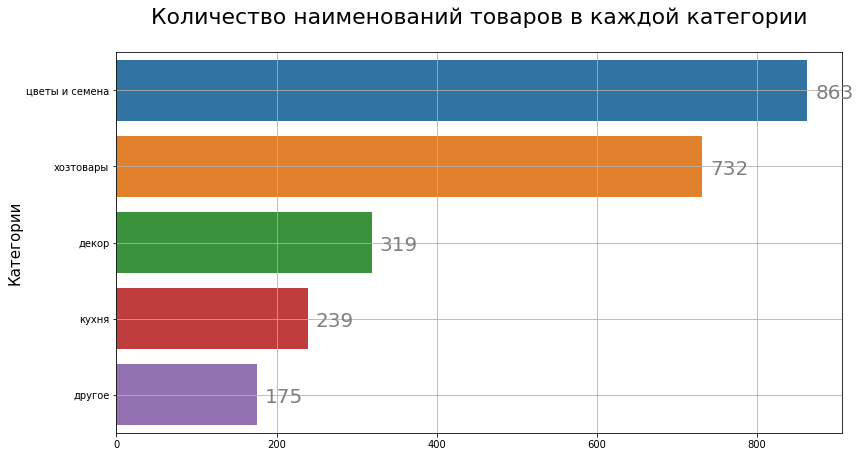

In [40]:
my_bar(count_product, 'category', 'product_category', 'Количество наименований товаров ' )

Больше всего уникальных наименований товаров в категории цветы и семена - 863; далее идут хозтовары - 732, декор - 319, кухня - 239, другое - 175. Можно сделать вывод, что график соответствует показателям числа заказов, которые мы получили ранее: больше всего заказов было совершено как раз в категории цветы и семена. То есть, больше заказов -  больше уникальных наименований.

#### Посчитаем сумму продаж каждой категории

In [41]:
count_items = df.groupby('category')['quantity'].sum().sort_values(ascending = False)
count_items = count_items.rename('items_category')
count_items = count_items.reset_index()

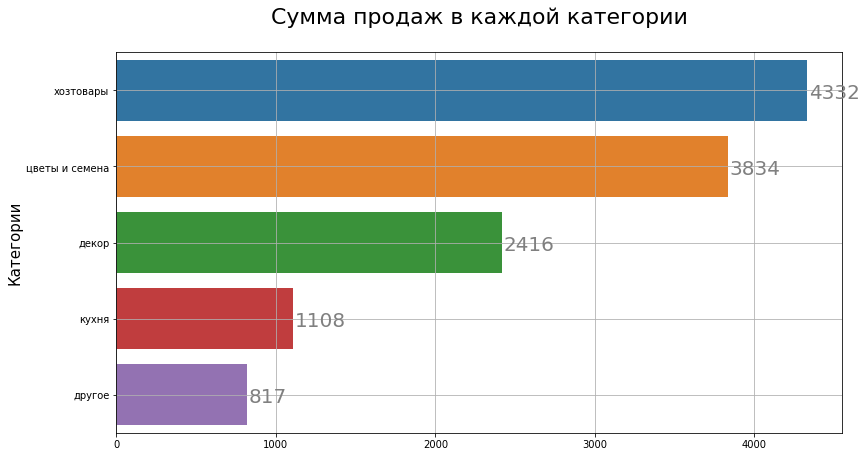

In [42]:
my_bar(count_items, 'category', 'items_category', 'Сумма продаж ' )

Судя по сумме всех продаж, большую выгоду принесли хозтовары - 4332, вероятно, что товары в этой категории самые дорогие, затем идут цветы и семена - 3834, эта категория самая большая по количеству заказов, а значит прибыльная.

#### Посчитаем среднюю стоимость товаров каждой категории

In [43]:
mean_price = df.groupby('category')['price'].mean().sort_values(ascending = False)
mean_price = mean_price.rename('price_category')
mean_price = mean_price.reset_index()

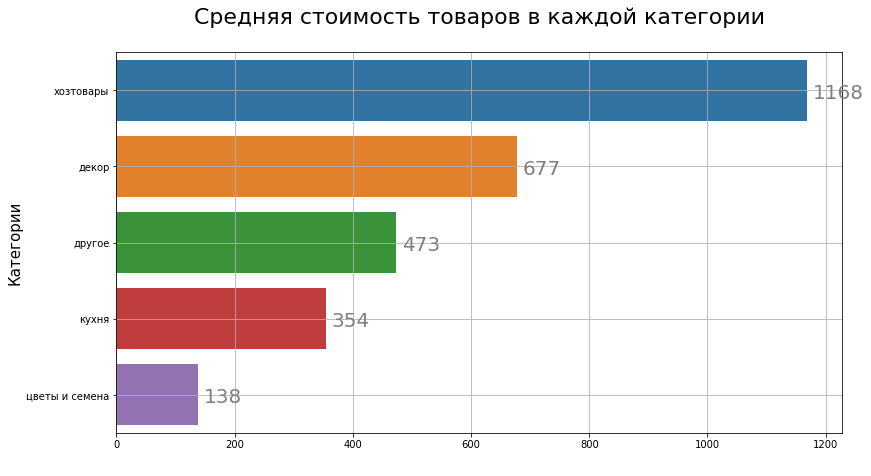

In [44]:
my_bar(mean_price, 'category', 'price_category', 'Средняя стоимость товаров ')

Вывод, сделанный ранее, что товары категории хозтовары самые дорогие, был верным. Его подтвердил график «Средней стоимости товаров в каждой категории». Затем идет категория декор. А вот в категории цветы и семена средняя стоимость товаров самая низкая.

Посмотрим на медианные значения и стандартные отклонения.

In [45]:
df.groupby('category')['price'].describe().T

category,декор,другое,кухня,хозтовары,цветы и семена
count,526.000000,200.000000,307.000000,1351.000000,2422.000000
mean,677.547529,473.790000,354.175896,1168.917098,138.397605
std,989.038887,796.248298,463.876239,1385.822878,161.988460
min,19.000000,9.000000,19.000000,15.000000,9.000000
25%,59.000000,82.000000,90.500000,363.000000,89.000000
50%,224.000000,194.000000,179.000000,697.000000,120.000000
75%,974.000000,472.000000,438.000000,1574.000000,150.000000
max,7349.000000,7229.000000,3299.000000,14917.000000,3599.000000


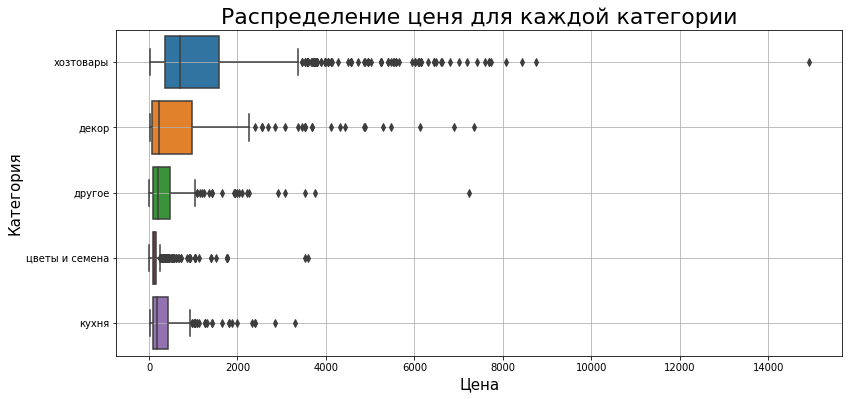

In [46]:
plt.figure(figsize=(13,6))
ax = sns.boxplot(data=df.sort_values('price', ascending = False), x='price', y='category')
plt.title('Распределение ценя для каждой категории', fontsize=22)
plt.ylabel('Категория', fontsize=15)
plt.xlabel('Цена', fontsize=15)
plt.grid()
plt.show()

Стандартное отклонение достаточно существенное, мы понимаем, что на среднюю цену повлияли выбросы, однако как мы и говорили, цены, кажущиеся аномально высокими, вполне реальные.

#### Определим суммарную выручку каждой категории

In [47]:
sum_price = df.groupby('category')['total'].sum().sort_values(ascending = False)
sum_price = sum_price.rename('sum_price')
sum_price = sum_price.reset_index()

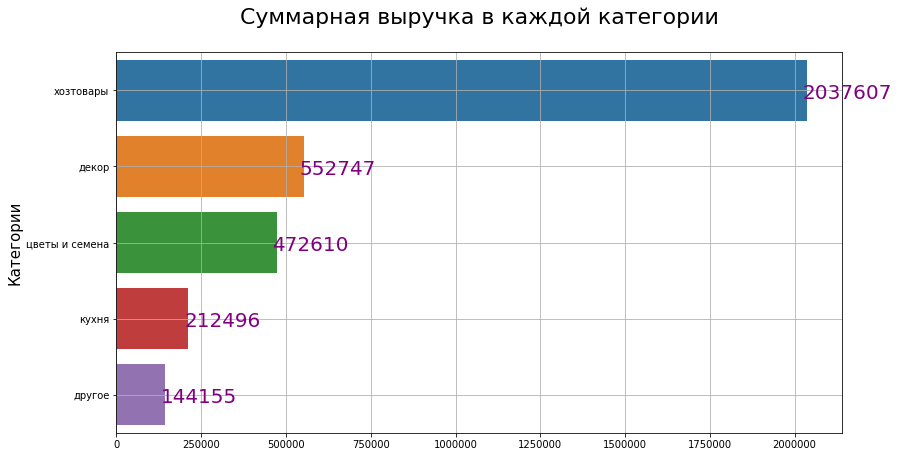

In [48]:
my_bar(sum_price, 'category', 'sum_price', 'Суммарная выручка ')

В отличие от средней стоимости за товар, суммарная выручка показала несколько другие результаты. Так, цветы и семена показали третий результат, хотя средняя стоимость товаров этой категории была самой низкой. Хозтовары и декор сохранили первые позиции.

#### Изучим сколько уникальных пользователей в каждой категории

In [49]:
count_id = df.groupby('category')['customer_id'].nunique().sort_values(ascending = False)
count_id = count_id.rename('id_category')
count_id = count_id.reset_index()

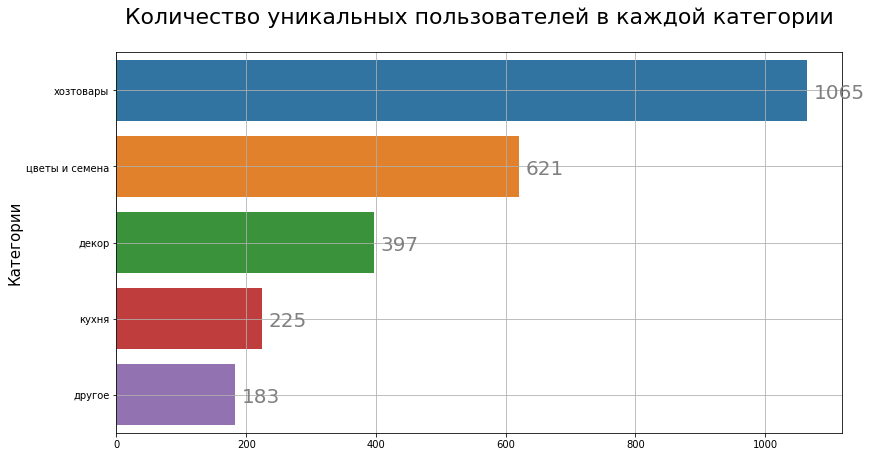

In [50]:
my_bar(count_id, 'category', 'id_category', 'Количество уникальных пользователей ')

Больше всего уникальных пользователей привлекает категория хозтовары, затем цветы и семена. С одной стороны, это самые объемные категории, понятно, что они привлекают больше уникальных пользователей, с другой - возможно стоит обратить внимание на менее востребованные категории, возможно они не очень удобны пользователю во время совершения покупок или нет подходящего товара.

#### Рассчитаем DAU, WAU и MAU

- DAU — количество уникальных пользователей в день;
- WAU — количество уникальных пользователей в неделю;
- MAU — количество уникальных пользователей в месяц.
Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках.

In [51]:
dau = df.groupby('date_day').agg({'customer_id': 'nunique'})
wau = df.groupby('date_week').agg({'customer_id': 'nunique'})
mau = df.groupby('date_month').agg({'customer_id': 'nunique'})

In [52]:
display(dau.mean(), wau.mean(), mau.mean())

customer_id    6.664962
dtype: float64

customer_id    43.327586
dtype: float64

customer_id    187.923077
dtype: float64

In [53]:
def my_plot(data, text):
    data.plot(grid = True, figsize = (13,7), linewidth=3, color='pink', legend = False)
    plt.title('Зависимость количества уникальных пользователей ' + text, fontsize=22)
    plt.xlabel('Дата', fontsize=15)
    plt.ylabel('Количество уникальных пользователей', fontsize=15)
    plt.show()

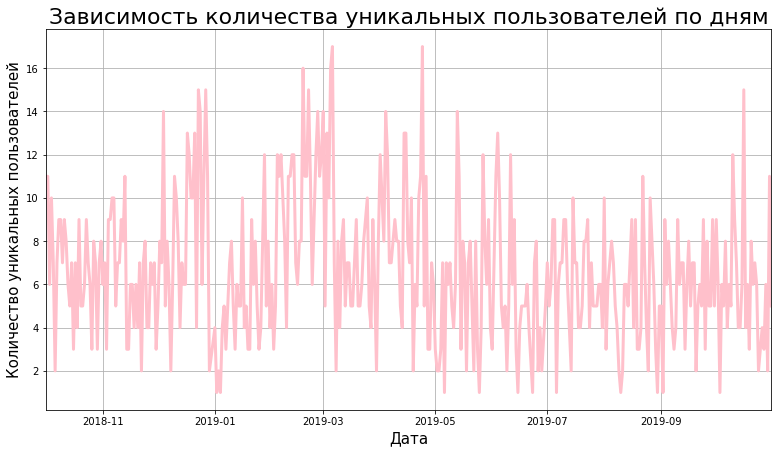

In [54]:
my_plot(dau, 'по дням')

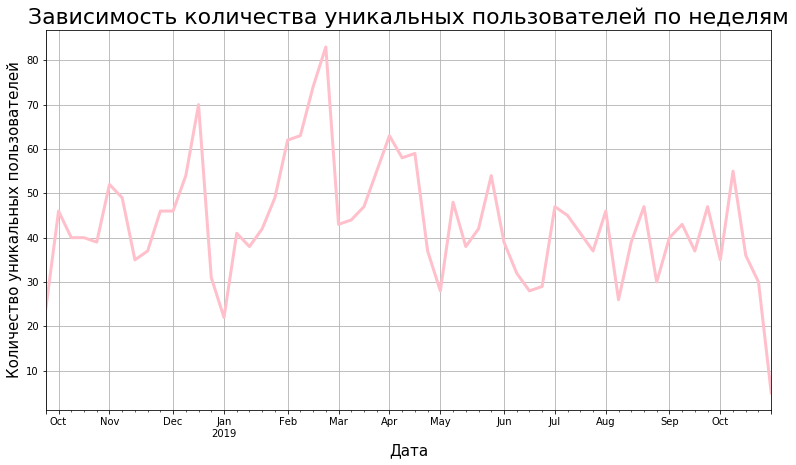

In [55]:
my_plot(wau, 'по неделям')

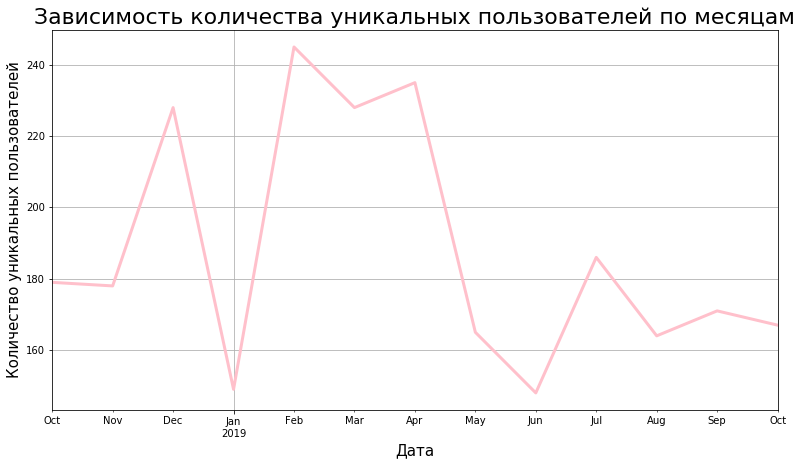

In [56]:
my_plot(mau, 'по месяцам')

Среднее значение DAU за указанный период - 6.7; WAU - 43.3; MAU - 187.9. На графиках видны изменения метрик во времени. Так, все три графика говорят о всплеске активности уникальных пользователей в середине декабря и в конце февраля - начале марта. Можно сделать вывод, что покупательская активность связана с предстоящими праздниками: Новый год, День защитника Отечества, 8 Марта. Спад наблюдается в конце мая, покупательская активность все летние месяцы находится на одном уровне. Возможно, он обоснован сезоном отпусков, а данные товары не относятся к этому сезону. Серьезные падения продаж могут быть связаны с длительными выходными, традиционно люди уезжают в отпуска, поэтому им не до покупок в январе и мае.

#### Рассчитаем количество покупателей в месяц для каждой категории

In [57]:
buyers_month = df.groupby(['date_month', 'category']).agg({'customer_id':'count'}).reset_index()

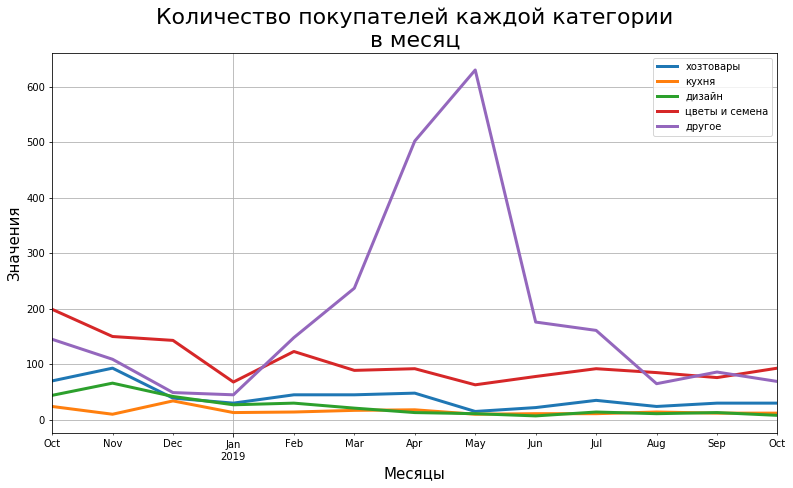

In [58]:
fig, ax = plt.subplots(figsize = (13, 7), sharey = True)

buyers_month.groupby('category').plot('date_month', 'customer_id', grid = True, ax = ax, linewidth=3)
plt.legend(('хозтовары', 'кухня', 'дизайн', 'цветы и семена', 'другое'))

plt.title('Количество покупателей каждой категории\nв месяц', fontsize=22)
plt.xlabel('Месяцы', fontsize=15)
plt.ylabel('Значения', fontsize=15)
plt.show()

С января по май есть резкий скачок категории другое, но мы не будем детально анализировать эту категории. Востребованность товаров из остальных категорий не зависит от времени года.

#### Изучим, соотношение основного ассортимента к дополнительному

In [59]:
main_additional = (
    df.groupby(['category', 'assortment'])['product'].count().reset_index()
    .rename(columns = {'product':'count'})
)
main_additional = pd.merge(main_additional, main_additional.groupby(['category'])['count'].sum()
                    .reset_index().rename(columns = {'count':'sum'}),
                    how = 'outer', on = 'category')

In [60]:
main_additional['percent'] = round(main_additional['count'] / main_additional['sum'] * 100, 1)
main_additional = main_additional.sort_values(['sum', 'category', 'assortment'], ascending = False)

In [61]:
def category_subplots(data, png_name, del_width, format_num, text):
    fig, ax = plt.subplots(figsize = (13, 7))
    ax1 = sns.barplot(x = 'percent', y = 'category', data = data, hue = 'assortment')
    
    """ Добавим на график подписи процентов """
    rects = ax1.patches
    texts = np.append(data.query('assortment == "основной"')['percent'].values,
                      data.query('assortment == "дополнительный"')['percent'].values)
    
    maxw = 0
    for rect, label in zip(rects, texts):
        width = rect.get_width()
        if np.isnan(width):
            continue
        ax1.text(width + del_width, rect.get_y() + 0.3, str(round(label, 2))+format_num,
                 color = 'k', ha = "center", fontsize = 15)
        if maxw < width:
            maxw = width
            
    
    leg = ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)
    leg.set_title('Ассортимент')
    ax.set_title('Соотношение основного и дополнительного ассортимента '+text, fontsize=22)
    ax.set_xlabel('Категории', fontsize=15)
    ax.set_ylabel('Проценты', fontsize=15)
    plt.grid()
    plt.show()

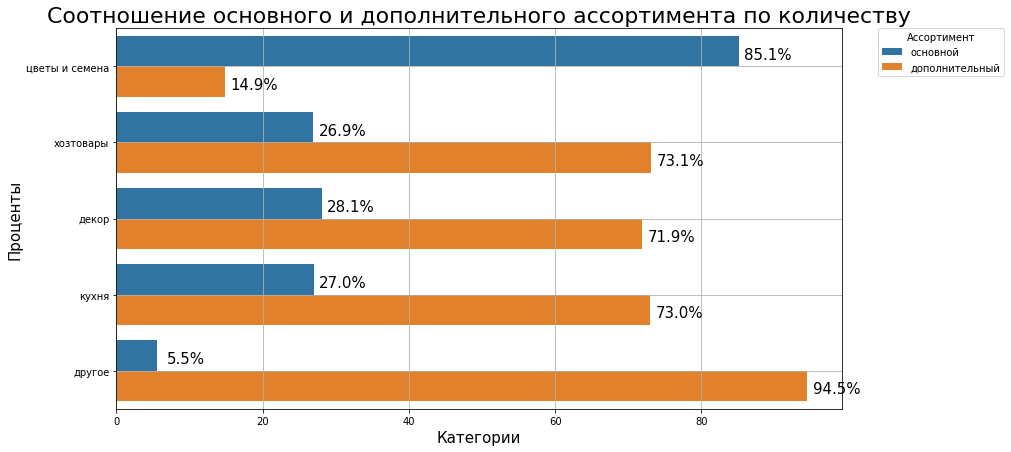

In [62]:
category_subplots(main_additional, 'category', 4, '%', 'по количеству')

##### Вывод

- Больше всего уникальных наименований товаров в категории цветы и семена - 863; далее идут хозтовары - 732, декор - 319, кухня - 239, другое - 175. Можно сделать вывод, что график соответствует показателям числа заказов, которые мы получили ранее: больше всего заказов было совершено как раз в категории цветы и семена. То есть, больше заказов - больше уникальных наименований.

- Судя по сумме всех продаж, большую выгоду принесли хозтовары - 4332, вероятно, что товары в этой категории самые дорогие, затем идут цветы и семена - 3834, эта категория самая большая по количеству заказов, а значит прибыльная.

- Вывод, сделанный ранее, что товары категории хозтовары самые дорогие, был верным. Его подтвердил график «Средней стоимости товаров в каждой категории». Затем идет категория декор. А вот в категории цветы и семена средняя стоимость товаров самая низкая. Также мы понимаем, что на среднюю цену повлияли выбросы, однако как мы и говорили, цены, кажущиеся аномально высокими, вполне реальные.

- В отличие от средней стоимости за товар, суммарная выручка показала несколько другие результаты. Так, цветы и семена показали третий результат, хотя средняя стоимость товаров этой категории была самой низкой. Хозтовары и декор сохранили первые позиции.

- Больше всего уникальных пользователей привлекает категория хозтовары, затем цветы и семена. С одной стороны, это самые объемные категории, понятно, что они привлекают больше уникальных пользователей, с другой - возможно стоит обратить внимание на менее востребованные категории, возможно они не очень удобны пользователю во время совершения покупок или нет подходящего товара.

- Среднее значение DAU за указанный период - 6.7; WAU - 43.3; MAU - 187.9. На графиках видны изменения метрик во времени. Так, все три графика говорят о всплеске активности уникальных пользователей в конце декабря и в конце февраля - начале марта. Можно сделать вывод, что покупательская активность связана с предстоящими праздниками: Новый год, День защитника Отечества, 8 Марта. Спад наблюдается в конце мая, покупательская активность все летние месяцы находится на одном уровне. Возможно, он обоснован сезоном отпусков, а данные товары не относятся к этому сезону. Серьезные падения продаж могут быть связаны с длительными выходными, традиционно люди уезжают в отпуска, поэтому им не до покупок в январе и мае.
- В четырех из пяти категорий, кроме категории цветы и семена, доля дополнительного ассортимента превышает основной.

### Шаг 4. Сформируем и проверим гипотезы

Проверяем первую гипотезу, что суммарная выручка в категориях товаров различается.

Формируем Н0 = "Средняя стоимость товаров в разных категориях товаров равна"

Пороговое значение alpha примем за 5%.

In [63]:
pvalue = pd.DataFrame()
def pvalue_category(cat1, cat2, one, two, i):
    alpha = 0.05
    results = st.ttest_ind(one, two)

    print('p-значение:', results.pvalue)
    
    pvalue.loc[cat1, cat2] = results.pvalue
    pvalue.loc[cat2, cat1] = results.pvalue
    if (results.pvalue < alpha):
        print("Средняя стоимость товаров в категориях '{}' и '{}' РАЗЛИЧАЕТСЯ".format(cat1, cat2))
    else:
        print("Средняя стоимость товаров в категориях '{}' и '{}' РАВНА".format(cat1, cat2))       

In [64]:
category = df['category'].unique()
i = 0
for cat1 in category:
    for cat2 in category:
        if cat1 == cat2:
            break
        print (i + 1, end = '. ')
        pvalue_category(cat2, cat1, df.query('category == @cat1')['price'],
                   df.query('category == @cat2')['price'], i)
        i += 1
        print ()

1. p-значение: 3.5533402532197136e-61
Средняя стоимость товаров в категориях 'цветы и семена' и 'другое' РАЗЛИЧАЕТСЯ

2. p-значение: 4.455398857962773e-246
Средняя стоимость товаров в категориях 'цветы и семена' и 'хозтовары' РАЗЛИЧАЕТСЯ

3. p-значение: 6.3575260013857735e-12
Средняя стоимость товаров в категориях 'другое' и 'хозтовары' РАЗЛИЧАЕТСЯ

4. p-значение: 3.558156278495244e-128
Средняя стоимость товаров в категориях 'цветы и семена' и 'декор' РАЗЛИЧАЕТСЯ

5. p-значение: 0.009259669105291704
Средняя стоимость товаров в категориях 'другое' и 'декор' РАЗЛИЧАЕТСЯ

6. p-значение: 1.66373993978035e-13
Средняя стоимость товаров в категориях 'хозтовары' и 'декор' РАЗЛИЧАЕТСЯ

7. p-значение: 2.0642630741268133e-57
Средняя стоимость товаров в категориях 'цветы и семена' и 'кухня' РАЗЛИЧАЕТСЯ

8. p-значение: 0.033264159292617536
Средняя стоимость товаров в категориях 'другое' и 'кухня' РАЗЛИЧАЕТСЯ

9. p-значение: 1.3077083258695505e-23
Средняя стоимость товаров в категориях 'хозтовары' и

Проверяем вторую гипотезу, что средняя стоимость товаров основного и дополнительного ассортиментов в категориях различается.

Формируем Н0 = "Средняя стоимость товаров основного и дополнительного ассортиментов в категориях равна"

Пороговое значение alpha примем за 5%.

In [65]:
pvalue_2 = pd.DataFrame()
def pvalue_cat(cat, one, two, i):
    alpha = 0.05
    results = st.ttest_ind(one, two)

    print('p-значение:', results.pvalue)
    
    pvalue_2.loc[i, 'category'] = cat
    if (results.pvalue < alpha):
        print(
            "Средняя стоимость товаров основного и дополнительного ассортиментов в категории '{}' - РАЗЛИЧАЕТСЯ"
            .format(cat)
        )    
    else:
        print(
            "Средняя стоимость товаров основного и дополнительного ассортиментов в категории '{}' - РАВНА"
            .format(cat)
        )

In [66]:
category = df['category'].unique()
i = 0
for cat in category:
    print (i + 1, end = '. ')
    pvalue_cat(cat, df.query('category == @cat and assortment == "основной"')['price'],
               df.query('category == @cat and assortment == "дополнительный"')['price'], i)
    i += 1
    print ()

1. p-значение: 1.7936965668364453e-23
Средняя стоимость товаров основного и дополнительного ассортиментов в категории 'цветы и семена' - РАЗЛИЧАЕТСЯ

2. p-значение: 0.17121616602210835
Средняя стоимость товаров основного и дополнительного ассортиментов в категории 'другое' - РАВНА

3. p-значение: 0.07839049267149686
Средняя стоимость товаров основного и дополнительного ассортиментов в категории 'хозтовары' - РАВНА

4. p-значение: 9.045643031147593e-06
Средняя стоимость товаров основного и дополнительного ассортиментов в категории 'декор' - РАЗЛИЧАЕТСЯ

5. p-значение: 0.0008765038030432486
Средняя стоимость товаров основного и дополнительного ассортиментов в категории 'кухня' - РАЗЛИЧАЕТСЯ



##### Вывод
Мы проверили две гипотезы. При пороговом значение alpha 5%, в первом случае подтвердилась гипотеза, что суммарная выручка различается в категориях: 
- 'цветы и семена' и 'другое'
- 'цветы и семена' и 'хозтовары' 
- 'другое' и 'хозтовары' 
- 'цветы и семена' и 'декор'
- 'другое' и 'декор' 
- 'хозтовары' и 'декор' 
- 'цветы и семена' и 'кухня' 
- 'хозтовары' и 'кухня' 
- 'декор' и 'кухня'
- 'другое' и 'кухня'


Во втором случае подтвердилась гипотеза, что средняя стоимость товаров основного и дополнительного ассортиментов в категориях различается в категориях:
- 'цветы и семена'
- 'декор' 
- 'кухня' 


Не подтвердилась в категориях:
- 'другое'
- 'хозтовары'

### Шаг 5. Напишем общий вывод и сделаем рекомендации

Мы провели анализ товарного ассортимента интернет-магазина, который продает товары для дома и быта. Перед нами стояла задача провести полноценный анализ товарного ассортимента и разобраться, какие товары входят в основной и дополнительный ассортимент. Такие меры необходимы, чтобы грамотно предлагать покупателям дополнительные товары и оптимизировать закупки магазина.


Мы располагаем данными с начала октября 2018 года по конец октября 2019 года. В нашем датасете изначально было более 6.7 тыс. строк, однако почти 30% данных пришлось удалить как дубли.  


Кроме того, мы поделили товары на пять категорий:
- цветы и семена – 2422 наименования
- хозтовары – 1352 наименования
- декор – 526 наименования
- кухня – 307 наименований
- другое – 200 наименований


И разделили ассортимент на основной и дополнительный:
- основной – 2668 наименований
- дополнительный – 2138 наименований



Больше всего уникальных наименований товаров в категории цветы и семена - 863; далее идут хозтовары - 732, декор - 319, кухня - 239, другое - 175. Можно сделать вывод, что график соответствует показателям числа заказов, которые мы получили ранее: больше всего заказов было совершено как раз в категории цветы и семена. То есть, больше заказов - больше уникальных наименований.

Судя по сумме всех продаж, большую выгоду принесли хозтовары - 4332, вероятно, что товары в этой категории самые дорогие, затем идут цветы и семена - 3834, эта категория самая большая по количеству заказов, а значит прибыльная.


Вывод, сделанный ранее, что товары категории хозтовары самые дорогие, был верным. Его подтвердил график «Средней стоимости товаров в каждой категории». Затем идет категория декор. А вот в категории цветы и семена средняя стоимость товаров самая низкая. Также мы понимаем, что на среднюю цену повлияли выбросы, однако как мы и говорили, цены, кажущиеся аномально высокими, вполне реальные.


В отличие от средней стоимости за товар, суммарная выручка показала несколько другие результаты. Так, цветы и семена показали третий результат, хотя средняя стоимость товаров этой категории была самой низкой. Хозтовары и декор сохранили первые позиции.


Больше всего уникальных пользователей привлекает категория хозтовары, затем цветы и семена. С одной стороны, это самые объемные категории, понятно, что они привлекают больше уникальных пользователей, с другой - возможно стоит обратить внимание на менее востребованные категории, возможно они не очень удобны пользователю во время совершения покупок или нет подходящего товара.


Среднее значение DAU за указанный период - 6.7; WAU - 43.3; MAU - 187.9. На графиках видны изменения метрик во времени. Так, все три графика говорят о всплеске активности уникальных пользователей в конце декабря и в конце февраля - начале марта. Можно сделать вывод, что покупательская активность связана с предстоящими праздниками: Новый год, День защитника Отечества, 8 Марта. Спад наблюдается в конце мая, покупательская активность все летние месяцы находится на одном уровне. Возможно, он обоснован сезоном отпусков, а данные товары не относятся к этому сезону. Серьезные падения продаж могут быть связаны с длительными выходными, традиционно люди уезжают в отпуска, поэтому им не до покупок в январе и мае. В четырех из пяти категорий, кроме категории цветы и семена, доля дополнительного ассортимента превышает основной. 


Мы проверили две гипотезы. При пороговом значение alpha 5%, в первом случае подтвердилась гипотеза, что суммарная выручка различается в категориях:
- 'цветы и семена' и 'другое'
- 'цветы и семена' и 'хозтовары'
- 'другое' и 'хозтовары'
- 'цветы и семена' и 'декор'
- 'другое' и 'декор'
- 'хозтовары' и 'декор'
- 'цветы и семена' и 'кухня'
- 'хозтовары' и 'кухня'
- 'декор' и 'кухня' 
- 'другое' и 'кухня'


Во втором случае подтвердилась гипотеза, что средняя стоимость товаров основного и дополнительного ассортиментов в категориях различается в категориях:
- 'цветы и семена'
- 'декор'
- 'кухня' 


Не подтвердилась в категориях:
- 'другое'
- 'хозтовары'

***Рекомендации***

- Провести более детальную категоризацию товаров. Так, можно добавить категории товаров, изучить и распределить данные из категории «другое». 
- Обратить внимание на категории, отстающие по показателям, возможно процесс покупки этих товаров неудобен пользователю или ассортимент слишком невелик. Пользователь попросту не находит то, что ему нужно.
- В тоже время, возможно, стоит сделать акцент на товарах из категории «цветы и семена». Есть смысл заняться только этой категорией, усилив ее, а как доптовары продавать сопутствующий садоводству ассортимент.